In [ ]:
import tensorflow as tf

import nobrainer
from nobrainer import dataset, volume

from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

dir_path = os.path.abspath("csv/faced_defaced/train_test_fold_1/csv/")
csv_path = os.path.join(dir_path, "training.csv")
# print(dir_path, csv_path)


labels = pd.read_csv(csv_path)["Y"].values
paths = pd.read_csv(csv_path)["X"].values


# print(labels)

n_classes=2
volume_shape = (256, 256, 256)
block_shape = (128, 128, 128)


training_paths = zip(paths, labels)

print(training_paths)

In [ ]:
import matplotlib 
# matplotlib.use('Agg')
import os, sys
sys.path.append('../defacing')

from preprocessing.normalization import clip, standardize, normalize
from preprocessing.conform import conform_data
from helpers.utils import load_vol, save_vol, is_gz_file
import numpy as np
import nibabel as nib
from glob import glob
import matplotlib.pyplot as plt
import tempfile

In [ ]:
import matplotlib 
# matplotlib.use('Agg')
import os, sys
sys.path.append('../defacing')
import subprocess

from preprocessing.normalization import clip, standardize, normalize
from preprocessing.conform import conform_data
from helpers.utils import load_vol, save_vol, is_gz_file
import numpy as np
import nibabel as nib
from glob import glob
import matplotlib.pyplot as plt
import tempfile


orig_root_dir = '/work/01329/poldrack/data/mriqc-net/data'
orig_data_face = os.path.join(orig_root_dir, 'face/T1w')
orig_data_mask = os.path.join(orig_root_dir, 'masks')

orig_data_deface = os.path.join(orig_root_dir, 'defaced')

save_root_dir = '/work/06850/sbansal6/maverick2/mriqc-shared/'

save_preprocessing_face = os.path.join(save_root_dir, 'preprocessing/face')
save_conformed_face = os.path.join(save_root_dir, 'conformed/face')

save_preprocessing_deface = os.path.join(save_root_dir, 'preprocessing/deface')
save_conformed_deface = os.path.join(save_root_dir, 'conformed/deface')

save_preprocessing_face_defaced = os.path.join(save_root_dir, 'preprocessing/face_defaced')
save_conformed_face_defaced = os.path.join(save_root_dir, 'conformed/face_defaced')

# os.makedirs(save_preprocessing_face, exist_ok=True)
os.makedirs(save_preprocessing_deface, exist_ok=True)
# os.makedirs(save_conformed_face, exist_ok=True)
os.makedirs(save_conformed_deface, exist_ok=True)

conform_size = (64, 64, 64)
conform_zoom = (4., 4., 4.)


def preprocess(orig_vol_pth, conform_pth, preprocess_pth, DS=None, mask_path=None, debug=False):
    """
    """
    
    filename = orig_vol_pth.split('/')[-1]
    volume, affine, _ = load_vol(orig_vol_pth)
    
    # Preprocessing
    volume = clip(volume, q=90)
    volume = normalize(volume)
    volume = standardize(volume)
    
    # 
    save_preprocessing_path = os.path.join(preprocess_pth, filename)
    save_conformed_path = os.path.join(conform_pth, filename)
    
    print("save_preprocessing_path: ", save_preprocessing_path)
    print("save_conformed_path: ", save_conformed_path)
    
    save_vol(save_preprocessing_path, volume, affine)

    def _plot(data):
        f, axarr = plt.subplots(8, 8, figsize=(12, 12))
        for i in range(8):
            for j in range(8):
                axarr[i, j].imshow(np.rot90(data[:, :, j + 8*i], 1))

        plt.show()
        
        
        plt.subplot(1, 3, 1)
        plt.imshow(np.rot90(np.mean(data, axis=0)))
        plt.subplot(1, 3, 2)
        plt.imshow(np.rot90(np.mean(data, axis=1)))
        plt.subplot(1, 3, 3)
        plt.imshow(np.rot90(np.mean(data, axis=2)))
        plt.show()
        
    conform_data(save_preprocessing_path, 
                 out_file=save_conformed_path, 
                 out_size=conform_size, 
                 out_zooms=conform_zoom)

    if debug: _plot(load_vol(save_conformed_path)[0])
    
    if mask_path and DS:
        mask = np.array(nib.load(mask_path).dataobj)
        masked_volume = volume*mask

        save_mpreprocessing_path = os.path.join(save_preprocessing_deface, DS, filename)
        save_mconformed_path = os.path.join(save_conformed_deface, DS, filename)
        
        print("save_deface_preprocessing_path: ", save_mpreprocessing_path)
        print("save_deface_conformed_path: ", save_mconformed_path)
        
#         os.makedirs(save_mpreprocessing_path, exist_ok=True)
        os.makedirs(os.path.dirname(save_mconformed_path), exist_ok=True)
    
#         save_mpreprocessing_path = os
        
        save_vol(save_mpreprocessing_path, masked_volume, affine)

        conform_data(save_mpreprocessing_path, 
                 out_file=save_mconformed_path, 
                 out_size=conform_size, 
                 out_zooms=conform_zoom)        
        
        return save_conformed_path, save_mconformed_path

    return save_conformed_path


# for path in glob(orig_data_face + "/ds000140_anat/*.nii*"):
# #     try:
        
#     vol_name = path.split("/")[-1]
#     DS = path.split("/")[-2]

#     # directories for saving preprocessed and conformed volumes
#     ds_save_conform_path = os.path.join(save_conformed_face, DS)
#     ds_save_preprocess_path = os.path.join(save_preprocessing_face, DS)

#     # Get the mask path
#     mask_path = glob(os.path.join(orig_data_mask, DS, vol_name.split('.')[0] + "*_mask*"))[0]

#     print("Mask_path", mask_path)

#     if not os.path.exists(ds_save_conform_path):
#         os.makedirs(ds_save_conform_path)

#     if not os.path.exists(ds_save_preprocess_path):
#         os.makedirs(ds_save_preprocess_path)

#     # Check if volume is a proper gunzipped
#     print(os.path.splitext(path)[1])
#     print("Gzipped: ", is_gz_file(path))
#     if os.path.splitext(path)[1] == ".gz" and not is_gz_file(path):
#         rename_file = os.path.splitext(vol_name)[0]
#         fixed_gz_tmp = os.path.join(save_conformed_face, rename_file)
#         print("Fixed GZIP File: ", fixed_gz_tmp)
#         subprocess.call(["cp", path, fixed_gz_tmp])

#         print(preprocess(fixed_gz_tmp,
#                          ds_save_conform_path,
#                          ds_save_preprocess_path,
#                          mask_path = mask_path,
#                          DS=DS
#                         ))
#         os.remove(fixed_gz_tmp)

#     else:
#         print(preprocess(path,
#                          ds_save_conform_path,
#                          ds_save_preprocess_path,
#                          mask_path = mask_path,
#                          DS=DS
#                         ))
#     except:
#         print("Preprocessing incomplete. Exception occurred.")
#         pass


for path in glob(orig_data_deface + "/*/*.nii*"):
    try:

        vol_name = path.split("/")[-1]
        DS = path.split("/")[-2]

        # directories for saving preprocessed and conformed volumes
        ds_save_conform_path = os.path.join(save_conformed_deface, DS)
        ds_save_preprocess_path = os.path.join(save_preprocessing_deface, DS)


        if not os.path.exists(ds_save_conform_path):
            os.makedirs(ds_save_conform_path)

        if not os.path.exists(ds_save_preprocess_path):
            os.makedirs(ds_save_preprocess_path)

        # Check if volume is a proper gunzipped
        if not os.path.splitext(path)[1] == ".gz" and is_gz_file(path):
            rename_file = os.path.splitext(vol_name)[0]
            fixed_gz_tmp = os.path.join(save_conformed_deface, rename_file)
            print(fixed_gz_tmp)
            subprocess.call(["cp", path, fixed_gz_tmp])

            print(preprocess(fixed_gz_tmp,
                             ds_save_conform_path,
                             ds_save_preprocess_path,
                             DS=DS
                            ))
            os.remove(fixed_gz_tmp)

        else:
            print(preprocess(path,
                             ds_save_conform_path,
                             ds_save_preprocess_path,
                             DS=DS
                            ))
    except:
        print("Preprocessing incomplete. Exception occurred.")
        pass



In [ ]:
orig_root_dir = '/work/01329/poldrack/data/mriqc-net/data'
orig_data_face = os.path.join(orig_root_dir, 'face/T1w')
# orig_data_mask = os.path.join(orig_root_dir, 'masks')

orig_data_deface = os.path.join(orig_root_dir, 'defaced')

save_root_dir = '/work/06850/sbansal6/maverick2/mriqc-shared/'

# save_preprocessing_face = os.path.join(save_root_dir, 'preprocessing/face')
save_conformed_face = os.path.join(save_root_dir, 'conformed/face')

save_preprocessing_deface = os.path.join(save_root_dir, 'preprocessing/deface')
save_conformed_deface = os.path.join(save_root_dir, 'conformed/deface')

save_conformed_face_defaced = os.path.join(save_root_dir, 'conformed/face_defaced')
# os.makedirs(save_preprocessing_face, exist_ok=True)
# os.makedirs(save_preprocessing_deface, exist_ok=True)
# os.makedirs(save_conformed_face, exist_ok=True)
# os.makedirs(save_conformed_deface, exist_ok=True)


def checkNonConformed(orig_path, save_path):

    conform = []
    orig = []

    for path in glob(save_path + "/*/*.nii*"):
        tempname = path.split("/")[-1]
        ds = path.split("/")[-2]
        conform.append(ds + "/" + tempname)

    print("Total Conformed: ", len(conform))

    for path in glob(orig_path + "/*/*.nii*"):
        tempname = path.split("/")[-1]
        ds = path.split("/")[-2]
        orig.append(ds + "/" + tempname)

    print("Total Original: ", len(orig))

    print("Total not conformed: ", len(orig) - len(conform))

    count = 0
    for f in orig:
        exists = False
        for fc in conform:
            if fc in f:
                exists = True
        if not exists:
            count += 1
            print("Not conformed file: ", f)
            

            
checkNonConformed(orig_data_face, save_conformed_face)


In [ ]:
face_C = []
face_O = []

for path in glob(save_data_face + "/*/*.nii*"):
    tempname = path.split("/")[-1]
    ds = path.split("/")[-2]
    face_C.append(ds + '/' + tempname)

print(len(face_C))
# print(face_C)


for path in glob(orig_data_face + "/*/*.nii*"):
    tempname = path.split("/")[-1]
    ds = path.split("/")[-2]
    face_O.append(ds + '/' + tempname)

print(len(face_O))
# print(face_O)

count = 0
for f in face_O:
    exists = False
    for fc in face_C:
        if fc in f:
            exists = True
    if not exists:
        count += 1
        print(f)
print(count)

## Generate n-fold CV Dataset

In [ ]:
import os, sys
sys.path.append("..")
import numpy as np
import nibabel as nb
from glob import glob
from pathlib import Path
from shutil import *
import subprocess
from operator import itemgetter
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import pandas as pd

face_path = "/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face"
deface_path = "/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface"
face_defaced_path = "/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face_defaced"

paths = []
labels = []

for path in glob(face_defaced_path + "/*/*.nii*"):
    paths.append(path)
    labels.append(0)
    
for path in glob(deface_path + "/*/*.nii*"):
    paths.append(path)
    labels.append(0)

for path in glob(face_path + "/*/*.nii*"):
    paths.append(path)
    labels.append(1)
    
print(len(paths))
print(len(labels))

save_path = "/work/06850/sbansal6/maverick2/mriqc-shared/experiment_data_all/csv_F15"

os.makedirs(save_path, exist_ok=True)

df = pd.DataFrame()
df["X"] = paths
df["Y"] = labels
df.to_csv(os.path.join(save_path, "all.csv"))

SPLITS = 15
skf = StratifiedKFold(n_splits=SPLITS)
fold_no = 1

for train_index, test_index in skf.split(paths, labels):
    out_path = save_path + "/train_test_fold_{}/csv/".format(fold_no)

    if not os.path.exists(out_path):
        os.makedirs(out_path)

    image_train, image_test = (
        itemgetter(*train_index)(paths),
        itemgetter(*test_index)(paths),
    )
    label_train, label_test = (
        itemgetter(*train_index)(labels),
        itemgetter(*test_index)(labels),
    )

    # image_train = [os.path.join(data_path, 'sub-' + str(pth) + '_T1w.nii.gz') for pth in image_train]
    train_data = {"X": image_train, "Y": label_train}
    df_train = pd.DataFrame(train_data)
    df_train.to_csv(os.path.join(out_path, "training.csv"), index=False)

    # image_test = [os.path.join(data_path, 'sub-' + str(pth) + '_T1w.nii.gz') for pth in image_test]
    validation_data = {"X": image_test, "Y": label_test}
    df_validation = pd.DataFrame(validation_data)
    df_validation.to_csv(os.path.join(out_path, "validation.csv"), index=False)

    fold_no += 1

## Generate tfrecords for n-fold CV Dataset


In [ ]:
import random
import nobrainer
import os, sys
sys.path.append("..")
import numpy as np
import nibabel as nb
from glob import glob
from pathlib import Path
from shutil import *
import subprocess
from operator import itemgetter
import pandas as pd

SPLITS = 15

for fold in range(6, SPLITS+1):
    
    dir_path = "/work/06850/sbansal6/maverick2/mriqc-shared/experiment_data_all/csv_F15/train_test_fold_{}/csv/".format(fold)
    tf_records_dir = "/work/06850/sbansal6/maverick2/mriqc-shared/experiment_data_all/tfrecords_F15/tfrecords_fold_{}/".format(fold)
    os.makedirs(tf_records_dir, exist_ok=True)
    
    train_csv_path = os.path.join(dir_path, "training.csv")
    valid_csv_path = os.path.join(dir_path, "validation.csv")
    
    train_paths = pd.read_csv(train_csv_path)["X"].values
    train_labels = pd.read_csv(train_csv_path)["Y"].values
    train_D = list(zip(train_paths, train_labels))
    random.shuffle(train_D)
#     print(train_D[0])
    
    valid_paths = pd.read_csv(valid_csv_path)["X"].values
    valid_labels = pd.read_csv(valid_csv_path)["Y"].values
    valid_D = list(zip(valid_paths, valid_labels))
    random.shuffle(valid_D)
    
    train_write_path = os.path.join(tf_records_dir, 'data-train_shard-{shard:03d}.tfrec')
    valid_write_path = os.path.join(tf_records_dir, 'data-valid_shard-{shard:03d}.tfrec')
    
    nobrainer.tfrecord.write(
        features_labels=train_D,
        filename_template=train_write_path,
        examples_per_shard=3)
    
    nobrainer.tfrecord.write(
        features_labels=valid_D,
        filename_template=valid_write_path,
        examples_per_shard=1)

## Generate Full Dataset

In [ ]:
import os, sys
sys.path.append("..")
import numpy as np
import nibabel as nb
from glob import glob
from pathlib import Path
from shutil import *
import subprocess
from operator import itemgetter
from sklearn.model_selection import train_test_split
import pandas as pd

face_path = "/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face"
deface_path = "/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface"

face_defaced_path = "/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face_defaced"

paths = []
labels = []

for path in glob(face_defaced_path + "/*/*.nii*"):
    paths.append(path)
    labels.append(0)
    
for path in glob(deface_path + "/*/*.nii*"):
    paths.append(path)
    labels.append(0)

for path in glob(face_path + "/*/*.nii*"):
    paths.append(path)
    labels.append(1)
    
print(len(paths))
print(len(labels))


# print(paths)
# X_train, X_test, y_train, y_test = train_test_split(paths, labels, test_size=0.15, random_state=123)

# print(X_train, y_train, stratify=True)

save_path = "/work/06850/sbansal6/maverick2/mriqc-shared/experiment_data_all/csv_final"
os.makedirs(save_path, exist_ok=True)

train_data = {"X": paths, "Y": labels}
df_train = pd.DataFrame(train_data)
df_train.to_csv(os.path.join(save_path, "training.csv"), index=False)

# validation_data = {"X": X_test, "Y": y_test}
# df_validation = pd.DataFrame(validation_data)
# df_validation.to_csv(os.path.join(save_path, "validation.csv"), index=False)


In [ ]:
import random
import nobrainer
import os, sys
sys.path.append("..")
import numpy as np
import nibabel as nb
from glob import glob
from pathlib import Path
from shutil import *
import subprocess
from operator import itemgetter
import pandas as pd

dir_path = "/work/06850/sbansal6/maverick2/mriqc-shared/experiment_data_all/csv_final"
tf_records_dir = "/work/06850/sbansal6/maverick2/mriqc-shared/experiment_data_all/tfrecords_final"
os.makedirs(tf_records_dir, exist_ok=True)

train_csv_path = os.path.join(dir_path, "training.csv")
# valid_csv_path = os.path.join(dir_path, "validation.csv")

train_paths = pd.read_csv(train_csv_path)["X"].values
train_labels = pd.read_csv(train_csv_path)["Y"].values
train_D = list(zip(train_paths, train_labels))
random.shuffle(train_D)
#     print(train_D[0])

# valid_paths = pd.read_csv(valid_csv_path)["X"].values
# valid_labels = pd.read_csv(valid_csv_path)["Y"].values
# valid_D = list(zip(valid_paths, valid_labels))
# random.shuffle(valid_D)

train_write_path = os.path.join(tf_records_dir, 'data-train_shard-{shard:03d}.tfrec')
# valid_write_path = os.path.join(tf_records_dir, 'data-valid_shard-{shard:03d}.tfrec')

nobrainer.tfrecord.write(
    features_labels=train_D,
    filename_template=train_write_path,
    examples_per_shard=3)

# nobrainer.tfrecord.write(
#     features_labels=valid_D,
#     filename_template=valid_write_path,
#     examples_per_shard=1)

In [ ]:
print(tf.random.uniform((1,)))

In [7]:
import os
import nobrainer
from nobrainer.io import _is_gzipped
from nobrainer.volume import to_blocks
import sys
sys.path.append('../defacing')
from helpers.utils import load_vol
import tensorflow_probability as tfp
import tensorflow as tf
import glob
import numpy as np

AUTOTUNE = tf.data.experimental.AUTOTUNE
ROOTDIR = '/work/06850/sbansal6/maverick2/mriqc-shared/experiment_data_all'
DISTRIBUTION = load_vol('../defacing/helpers/distribution.nii.gz')[0]
DISTRIBUTION /= DISTRIBUTION.sum()

sampler = lambda n: np.array([ np.unravel_index(
          np.random.choice(np.arange(np.prod(DISTRIBUTION.shape)),
                                     p = DISTRIBUTION.ravel()),
          DISTRIBUTION.shape) for _ in range(n)]) 


# function to apply augmentations to tf dataset
def apply_augmentations(features, labels):

    """ Apply <TYPE_OF> augmentation to the dataset

    """
    
    
    return

def _magic_slicing_(shape):
    """
    """
    idx = []
    for ii in np.arange(shape[0]):
        if (ii % shape[0]**0.5) == 0:
            idx.append(ii)
    idx = np.array(idx)
    return idx


def get_dataset(
    file_pattern,
    n_classes,
    batch_size,
    volume_shape,
    plane,
    n = 24,
    block_shape=None,
    n_epochs=None,
    mapping=None,
    augment=False,
    shuffle_buffer_size=None,
    num_parallel_calls=AUTOTUNE,
):

    """ Returns tf.data.Dataset after preprocessing from
    tfrecords for training and validation

    Parameters
    ----------
    file_pattern:

    n_classes:

    """

    files = glob.glob(file_pattern)

    if not files:
        raise ValueError("no files found for pattern '{}'".format(file_pattern))

    compressed = _is_gzipped(files[0])
    shuffle = bool(shuffle_buffer_size)

    ds = nobrainer.dataset.tfrecord_dataset(
        file_pattern=file_pattern,
        volume_shape=volume_shape,
        shuffle=shuffle,
        scalar_label=True,
        compressed=compressed,
        num_parallel_calls=num_parallel_calls,
    )
    

    if augment:
        ds = ds.map(
            lambda x, y: tf.cond(
                tf.random.uniform((1,)) > 0.5,
                true_fn=lambda: nobrainer.volume.apply_random_transform_scalar_labels(x, y),
                false_fn=lambda: (x, y),
            ),
            num_parallel_calls=num_parallel_calls,
        )
        

    def _ss(x, y):
        x, y = structural_slice(x, y, plane, n)
        return (x, y)

    ds = ds.map(_ss, num_parallel_calls)

    #     def _f(x, y):
    #         x = to_blocks(x, block_shape)
    #         n_blocks = x.shape[0]
    #         y = tf.repeat(y, n_blocks)
    #         return (x, y)
    #     ds = ds.map(_f, num_parallel_calls=num_parallel_calls)

    # This step is necessary because it reduces the extra dimension.
    # ds = ds.unbatch()


    ds = ds.prefetch(buffer_size=batch_size)
    def reshape(x,y):
        if plane == "combined":
            for _ in 3:
                pass
        return (x, y)
    if batch_size is not None:
        ds = ds.batch(batch_size=batch_size, drop_remainder=True)

    if shuffle_buffer_size:
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat the dataset n_epochs times
#     ds = ds.repeat(n_epochs)

    return ds


def structural_slice(x, y, plane, n=4):

    """ Transpose dataset based on the plane

    Parameters
    ----------
    x:

    y:

    plane:

    """

    options = ["axial", "coronal", "sagittal", "combined"]
    shape = np.array(x.shape)

    if isinstance(plane, str) and plane in options:
        if plane == "axial":
            idx = np.random.randint(shape[0]**0.5)
            midx = sampler(n)[:, 0]
            x = x
            k = 3

        if plane == "coronal":
            idx = np.random.randint(shape[1]**0.5)
            midx = sampler(n)[:, 1]
            x = tf.transpose(x, perm=[1, 2, 0])
            k = 2

        if plane == "sagittal":
            idx = np.random.randint(shape[2]**0.5)
            midx = sampler(n)[:, 2]
            x = tf.transpose(x, perm=[2, 0, 1])
            k = 1

        if plane == "combined":
            temp = {}
            for op in options[:-1]:
                temp[op] = structural_slice(x, y, op, n)[0]
            x = temp

        if not plane == "combined":
            x = tf.squeeze(tf.gather_nd(x, midx.reshape(n, 1, 1)), axis=1)
            x = tf.math.reduce_mean(x, axis=0)
            x = tf.convert_to_tensor(tf.expand_dims(x, axis=-1))
            x =  tf.image.rot90(
                   x, k, name=None
                )

        return x, y
    else:
        raise ValueError("expected plane to be one of ['axial', 'coronal', 'sagittal']")



if __name__ == "__main__":

    n_classes = 2
    global_batch_size = 8
    volume_shape = (64, 64, 64)
    ds_train = get_dataset(
        os.path.join(ROOTDIR, "tfrecords_F15/tfrecords_fold_1/data-train_*"),
        augment=True,
        n_classes=n_classes,
        batch_size=global_batch_size,
        volume_shape=volume_shape,
        plane="combined",
        shuffle_buffer_size=3,
    )
    
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt

    print(ds_train)
#     ds_train = np.array(list(ds_train.as_numpy_iterator()))
#     print(len(list(ds_train.as_numpy_iterator())))
    
    
#     for ii in range(100):
#         x,y=next(ds.as_numpy_iterator())
#         # print (np.min(x), np.max(x), np.unique(y))
#         count = 1
#         for i in range(global_batch_size):
#             for key in x.keys():
#                 plt.subplot(global_batch_size, 3, count)
#                 plt.imshow(x[key][i, :, :, 0])
#                 plt.title(str(y[i]))
#                 plt.xticks([]," ")
#                 plt.yticks([], " ")
#                 count += 1
#         plt.savefig("processed_data_samples/processed_image_combined_{}.png".format(ii))


# dataset_train_coronal = get_dataset("tfrecords/tfrecords_fold_1/data-train_*",
#                             n_classes=n_classes,
#                             batch_size=global_batch_size,
#                             volume_shape=volume_shape,
#                             block_shape=block_shape,
#                             plane='coronal',
#                             shuffle_buffer_size=3)

# dataset_train_sagittal = get_dataset("tfrecords/tfrecords_fold_1/data-train_*",
#                             n_classes=n_classes,
#                             batch_size=global_batch_size,
#                             volume_shape=volume_shape,
#                             block_shape=block_shape,
#                             plane='sagittal',
#                             shuffle_buffer_size=3)


<ShuffleDataset shapes: ({axial: (8, 64, 64, 1), coronal: (8, 64, 64, 1), sagittal: (8, 64, 64, 1)}, (8, 1)), types: ({axial: tf.float32, coronal: tf.float32, sagittal: tf.float32}, tf.float32)>


In [ ]:
print(ds_train.shape)

In [ ]:
import pandas as pd
fold = 1
dir_path = "/work/06850/sbansal6/maverick2/mriqc-shared/experiment_data_all/csv_F15/train_test_fold_{}/csv/".format(fold)

train_csv_path = os.path.join(dir_path, "training.csv")
valid_csv_path = os.path.join(dir_path, "validation.csv")

train_paths = pd.read_csv(train_csv_path)["X"].values
valid_paths = pd.read_csv(valid_csv_path)["X"].values

train_labels = pd.read_csv(train_csv_path)["Y"].values
valid_labels = pd.read_csv(valid_csv_path)["Y"].values

print(type(train_labels))

from sklearn.utils import class_weight

weights = class_weight.compute_class_weight('balanced',
                                            np.unique(train_labels),
                                            train_labels)

print(dict(enumerate(weights)))

In [ ]:
# Std packages
import sys, os
import glob
import math

sys.path.append("../defacing")

# Custom packages
from models import modelN
# from dataloaders.dataset import get_dataset

# Tf packages
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.utils import class_weight
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    LearningRateScheduler,
    TensorBoard,
)
# import nobrainer
from tensorflow.keras import metrics
from tensorflow.keras import losses

ROOTDIR = "/work/06850/sbansal6/maverick2/mriqc-shared/experiment_data_all/"


def scheduler(epoch):
    if epoch < 3:
        return 0.001
    else:
        return 0.001 * tf.math.exp(0.1 * (10 - epoch))


def train(
    volume_shape=(64, 64, 64),
    image_size=(64, 64),
    dropout=0.2,
    batch_size=16,
    n_classes=2,
    n_epochs=15,
    fold=1
):
    
    
#     print("FOLD {}".format(fold))
    dir_path = os.path.join(ROOTDIR, "csv_final/")

    train_csv_path = os.path.join(dir_path, "training.csv")
#     valid_csv_path = os.path.join(dir_path, "validation.csv")

    train_paths = pd.read_csv(train_csv_path)["X"].values
#     valid_paths = pd.read_csv(valid_csv_path)["X"].values
    
    train_labels = pd.read_csv(train_csv_path)["Y"].values
#     valid_labels = pd.read_csv(valid_csv_path)["Y"].values
    
    weights = class_weight.compute_class_weight('balanced',
                                                np.unique(train_labels),
                                                train_labels)
    weights = dict(enumerate(weights))
    
    print(weights)
    
    planes = ["axial", "coronal", "sagittal", "combined"]

#     strategy = tf.distribute.MirroredStrategy()
#     BATCH_SIZE_PER_REPLICA = batch_size
#     global_batch_size = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

    global_batch_size = batch_size
    
    model_save_path = os.path.join(ROOTDIR, "model_save_dir_final_1")
    
    os.makedirs(model_save_path, exist_ok=True)

    cp_save_path = os.path.join(model_save_path, "weights")

    logdir_path = os.path.join(model_save_path, "tb_logs")
    if not os.path.exists(logdir_path):
        os.makedirs(logdir_path)

    for plane in planes:

        logdir = os.path.join(logdir_path, plane)
        os.makedirs(logdir, exist_ok=True)

        tbCallback = TensorBoard(
            log_dir=logdir, histogram_freq=1, write_graph=True, write_images=True,
        )

        os.makedirs(os.path.join(cp_save_path, plane), exist_ok=True)

        model_checkpoint = ModelCheckpoint(
            os.path.join(cp_save_path, plane, "best-wts.h5"),
            monitor="val_loss",
            save_weights_only=True,
            mode="min",
        )

#         with strategy.scope():

        if not plane == "combined": 
            lr = 1e-3
            model = modelN.Submodel(
                input_shape=image_size,
                dropout=dropout,
                name=plane,
                include_top=True,
                weights=None,
            )
        else:
            lr = 5e-4
            model = modelN.CombinedClassifier(
                input_shape=image_size,
                dropout=dropout,
                trainable=True,
                wts_root=cp_save_path,
            )

        print("Submodel: ", plane)
#         print(model.summary())

        METRICS = [
            metrics.TruePositives(name="tp"),
            metrics.FalsePositives(name="fp"),
            metrics.TrueNegatives(name="tn"),
            metrics.FalseNegatives(name="fn"),
            metrics.BinaryAccuracy(name="accuracy"),
            metrics.Precision(name="precision"),
            metrics.Recall(name="recall"),
            metrics.AUC(name="auc"),
        ]

        model.compile(
            loss=tf.keras.losses.binary_crossentropy,
            optimizer=Adam(learning_rate=lr),
            metrics=METRICS,
        )

        print("GLOBAL BATCH SIZE: ", global_batch_size)

        dataset_train = get_dataset(
            file_pattern=os.path.join(ROOTDIR, "tfrecords_final/data-train_*"),
            n_classes=n_classes,
            batch_size=global_batch_size,
            volume_shape=volume_shape,
            plane=plane,
            shuffle_buffer_size=global_batch_size,
        )

#         dataset_valid = get_dataset(
#             file_pattern=os.path.join(ROOTDIR, "tfrecords_F15/tfrecords_fold_{}/data-valid_*".format(fold)),
#             n_classes=n_classes,
#             batch_size=global_batch_size,
#             volume_shape=volume_shape,
#             plane=plane,
#             shuffle_buffer_size=global_batch_size,
#         )
        
        steps_per_epoch = math.ceil(len(train_paths)/batch_size)

#         validation_steps = math.ceil(len(valid_paths)/batch_size)

        print(steps_per_epoch)
    

        lrcallback = tf.keras.callbacks.LearningRateScheduler(scheduler)
        
        model.fit(
            dataset_train,
            epochs=n_epochs,
            steps_per_epoch=steps_per_epoch,
#             validation_data=dataset_valid,
#             validation_steps=validation_steps,
            callbacks=[tbCallback, model_checkpoint],
            class_weight = weights,
        )

        del model
        K.clear_session()


if __name__ == "__main__":
#     for fold in range(1, 16):
    train()


## Inference

In [2]:
import os
import sys
import time
import imgaug
import shutil
import numpy as np
from imgaug import augmenters as iaa
import matplotlib.pyplot as plt

sys.path.append('../defacing')
from helpers.utils import save_vol, load_vol
from preprocessing.conform import conform_data
from preprocessing.normalization import clip, standardize, normalize

import tensorflow as tf


class DataGeneratoronFly(object):
    """
    """

    def __init__(self, conform_size=(64, 64, 64),
                        conform_zoom=(4., 4., 4.), 
                        nchannels=1, 
                        nruns=8,
                        nsamples=20,
                        save=False, 
                        transform=None):

        self.conform_size=conform_size
        self.conform_zoom=conform_zoom
        self.nchannels=nchannels
        self.transform=transform
        self.nsamples=nsamples
        self.nruns=nruns
        self.save=save
        DISTRIBUTION = load_vol('../defacing/helpers/distribution.nii.gz')[0]
        assert DISTRIBUTION.shape == conform_size, "Invalid conform_size needs to regenerate face distribution"

        DISTRIBUTION /= DISTRIBUTION.sum()
        self.sampler = lambda n: np.array([ np.unravel_index(
                  np.random.choice(np.arange(np.prod(DISTRIBUTION.shape)),
                                             p = DISTRIBUTION.ravel()),
                  DISTRIBUTION.shape) for _ in range(n)]) 



    def _augmentation(self, volume):
        r"""
                Augmenters that are safe to apply to masks
                Some, such as Affine, have settings that make them unsafe, so always
                test your augmentation on masks
        """
        volume_shape = volume.shape
        det = self.transform.to_deterministic()
        volume = det.augment_image(volume)

        assert volume.shape == volume_shape, "Augmentation shouldn't change volume size"
        return volume


    def _sample_slices(self, volume, plane=None):

        options = ["axial", "coronal", "sagittal", "combined"]
        assert plane in options, "expected plane to be one of ['axial', 'coronal', 'sagittal']"
        samples = self.sampler(self.nsamples)

        if plane == "axial":
            midx = samples[:, 0]
            volume = volume
            k = 3

        if plane == "coronal":
            midx = samples[:, 1]
            volume = np.transpose(volume, axes=[1, 2, 0])
            k = 2

        if plane == "sagittal":
            midx = samples[:, 2]
            volume = np.transpose(volume, axes=[2, 0, 1])
            k = 1

        if plane == "combined":
            temp = []
            for op in options[:-1]:
                temp.append(self._sample_slices(volume, op))
            volume = temp
#             plt.subplot(1, 3, 1)
#             plt.imshow(volume[0][:,:,0])
#             plt.subplot(1, 3, 2)
#             plt.imshow(volume[1][:,:,0])
#             plt.subplot(1, 3, 3)
#             plt.imshow(volume[2][:,:,0])
#             plt.show()

        if not plane == "combined":
            volume = np.squeeze(volume[midx,:,:])
            volume = np.mean(volume, axis=0)
            volume = np.rot90(volume, k)
            volume = volume[..., None]
        return volume


    def get_data(self, volume):
        # Generate indexes of the batch
        volume = clip(volume, q=90)
        volume = normalize(volume)
        volume = standardize(volume)
        newaffine = np.eye(4)
        newaffine[:3, 3] = -0.5 * (np.array(self.conform_size) - 1)
        os.makedirs('./tmp', exist_ok=True)
        save_vol('./tmp/Pre-processing.nii.gz', volume, newaffine)
        conform_data('./tmp/Pre-processing.nii.gz',
                        './tmp/Conformed.nii.gz',
                        self.conform_size,
                        self.conform_zoom)

        volume = load_vol('./tmp/Conformed.nii.gz')[0]

        if self.transform:
            volume = self._augmentation(volume)

        slices = []
        for _ in range(self.nruns):
            slices.append(self._sample_slices(volume, 
                                    plane="combined"))

        if not self.save: 
            shutil.rmtree('./tmp')
        return slices

    
if __name__=="__main__":
    
    path = '../sample_vols/defaced/example2.nii.gz'
    
    vol, _, _ = load_vol(path)
    
    
    inference_transform_params = {
            "conform_size": (64, 64, 64),
            "conform_zoom": (4., 4., 4.), 
            "nchannels": 1, 
            "nruns": 8,
            "nsamples": 24,
            "save": False, 
            "transform": None
        }
    
    inference_generator = DataGeneratoronFly(**inference_transform_params)
    
    slices = inference_generator.get_data(vol)
    
    slices = np.transpose(np.array(slices),axes=[1, 0, 2, 3, 4])
    ds = {}
    ds['axial'] = slices[0]
    ds['coronal'] = slices[1]
    ds['sagittal'] = slices[2]
    
#     print(ds)
    print(slices.shape)
#         return slices

(3, 8, 64, 64, 1)


In [ ]:
import os
import sys
import numpy as np
import tensorflow as tf
import timeit

sys.path.append('../defacing')
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from models.modelN import CombinedClassifier
# from dataloaders.inference_dataloader import DataGeneratoronFly

ROOTDIR = "/work/06850/sbansal6/maverick2/mriqc-shared/experiment_data_all"


class inferer(object):
    """
       nMontecarlo: for multiple exp for same model
       quick: checks for all 3 fold models
       mode: method to merge predictions
             allowed ['avg', 'max_vote']
    """

    def __init__(self, nMontecarlo=8, mode="avg"):
        r"""
        """
        inference_transform_params = {
            "conform_size": (64, 64, 64),
            "conform_zoom": (4., 4., 4.), 
            "nchannels": 1, 
            "nruns": 8,
            "nsamples": 20,
            "save": False, 
            "transform": None
        }

        self.mode = mode
        assert self.mode.lower() in [
            "avg",
            "max_vote",
        ], "unknown mode, allowed mode are ['avg', 'max_vote']"

        self.inference_generator = DataGeneratoronFly(**inference_transform_params)
        self.model = CombinedClassifier(
            input_shape=(64, 64), dropout=0.4, wts_root=None, trainable=True
        )
        self.model.load_weights(

            os.path.abspath(os.path.join(ROOTDIR, "model_save_dir_final_1/weights/combined/best-wts.h5"))
        )

    def infer(self, vol):
        """
        vol : can be numpy ndarray or path to volume
        """
        slices = self.inference_generator.get_data(vol)
        slices = np.transpose(np.array(slices),axes=[1, 0, 2, 3, 4])
        
        ds = {}
        ds['axial'] = slices[0]
        ds['coronal'] = slices[1]
        ds['sagittal'] = slices[2]
    
        predictions = self.model.predict(ds)

        if self.mode.lower() == "max_vote":
            predictions = np.round(predictions)
            unique_elements = np.unique(predictions)
            count_array = np.array(
                [
                    sum(predictions == unique_element)
                    for unique_element in unique_elements
                ]
            )
            pred = (
                np.argmax(count_array) if len(count_array) > 1 else unique_elements[0]
            )
            conf = (
                1
                if len(count_array) == 1
                else count_array[pred] * 1.0 / np.sum(count_array)
            )
        elif self.mode.lower() == "avg":
            conf = np.mean(predictions)
            pred = np.round(conf)

        pred_str = "faced" if pred == 1 else "defaced"
        conf = conf if pred == 1 else 1.0 - conf

        print("[INFO] Given volume is " + pred_str + " with confidence of: {}".format(conf))
        
#         del self.model
#         K.clear_session()
        
        return pred, conf


In [4]:
import os
import sys
import numpy as np
import tensorflow as tf
import timeit
import shap
import glob

sys.path.append('../defacing')
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from models.modelN import CombinedClassifier

ROOTDIR = "/work/06850/sbansal6/maverick2/mriqc-shared/experiment_data_all"


model = CombinedClassifier(
            input_shape=(64, 64), dropout=0.4, wts_root=None, trainable=True
        )

model.load_weights(

            os.path.abspath(os.path.join(ROOTDIR, "model_save_dir_final_1/weights/combined/best-wts.h5"))
        )

paths = glob.glob('/work/01329/poldrack/data/mriqc-net/data/test_images/test1_images/*/*')
file = paths[0]
vol, _, _ = load_vol(file)


inference_transform_params = {
    "conform_size": (64, 64, 64),
    "conform_zoom": (4., 4., 4.), 
    "nchannels": 1, 
    "nruns": 8,
    "nsamples": 20,
    "save": False, 
    "transform": None
}


inference_generator = DataGeneratoronFly(**inference_transform_params)

        
slices = inference_generator.get_data(vol)
slices = np.transpose(np.array(slices),axes=[1, 0, 2, 3, 4])
        
ds = {}
ds['axial'] = slices[0]
ds['coronal'] = slices[1]
ds['sagittal'] = slices[2]
# print(ds)


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
axial (InputLayer)              [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
sagittal (InputLayer)           [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
coronal (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 8)    80          axial[0][0]                      
____________________________________________________________________________________________

In [ ]:
import sys
import glob
sys.path.append('../defacing')
from helpers.utils import load_vol
# from defacing.inference import inferer

_inferer = inferer()
# path = '../sample_vols/faced/example1.nii.gz'
paths = glob.glob('/work/01329/poldrack/data/mriqc-net/data/test_images/test1_images/*/*')

inf = {}

for file in paths:
    print(file)
    temp = {}
    vol, _, _ = load_vol(file)
    label, conf = _inferer.infer(vol)
    temp['label'] = label
    temp['confidence'] = conf
    inf[file.split('/')[-2] + '/' + file.split('/')[-1]] = temp

In [ ]:
import pandas as pd

df = pd.DataFrame.from_dict(inf).transpose()

df.to_csv('test_inference_aug.csv')

In [ ]:
import pandas as pd

inference_results_path = 'test_inference.csv'
data = pd.read_csv(inference_results_path)
data.rename(columns={'Unnamed: 0':'volume'}, inplace=True )


true_labels = pd.read_csv('/work/06850/sbansal6/maverick2/mriqc-net/2.5D/csv/faced/all.csv')

In [ ]:
volumes, tlabels = true_labels['X'].values, true_labels['Y'].values

tvolumes = {}

for v in range(len(volumes)):
    
    tvolumes[volumes[v].split('/')[-2] + '/' + volumes[v].split('/')[-1]] = tlabels[v]
    

In [4]:
import pandas as pd

true_labels = pd.read_csv('test1_images_gt.csv')
tl_dict = {}
for i, row in enumerate(true_labels.values):
    
    dataset, volume, label = row
    l = 0 if 'deface' in label else 1
    tl_dict[str(dataset) + '/' + str(volume)] = l
    
# print(tl_dict)
    

predicted = pd.read_csv('test_inference.csv')
predicted.rename(columns={'Unnamed: 0':'volume'}, inplace=True )

correct = 0
incorrect = {}
for i, row in enumerate(predicted.values):
    volume, confidence, label = row
    
    if volume in tl_dict:
        if label == tl_dict[volume]:
            correct += 1
        else:
#             print(volume, confidence, label)
            incorrect[volume] = {}
            incorrect[volume]['label'] = label
            incorrect[volume]['confidence'] = confidence
            
print(incorrect)

{'ds002330/sub-10_T1w.nii.gz': {'label': 1.0, 'confidence': 0.5310509204864502}, 'ds002330/sub-65_T1w.nii.gz': {'label': 1.0, 'confidence': 0.989669144153595}, 'ds002330/sub-52_T1w.nii.gz': {'label': 1.0, 'confidence': 0.7102487087249756}, 'ds002330/sub-45_T1w.nii.gz': {'label': 1.0, 'confidence': 0.9746917486190796}, 'ds002330/sub-26_T1w.nii.gz': {'label': 1.0, 'confidence': 0.6372390985488892}, 'ds002330/sub-04_T1w.nii.gz': {'label': 1.0, 'confidence': 0.5091515183448792}, 'ds002330/sub-44_T1w.nii.gz': {'label': 1.0, 'confidence': 0.9371259212493896}, 'ds002330/sub-51_T1w.nii.gz': {'label': 1.0, 'confidence': 0.5763907432556152}, 'ds002330/sub-06_T1w.nii.gz': {'label': 1.0, 'confidence': 0.996864914894104}, 'ds002330/sub-31_T1w.nii.gz': {'label': 1.0, 'confidence': 0.9928882122039796}, 'ds002330/sub-02_T1w.nii.gz': {'label': 1.0, 'confidence': 0.9093393683433532}, 'ds002330/sub-63_T1w.nii.gz': {'label': 1.0, 'confidence': 0.9848501086235046}, 'ds002330/sub-21_T1w.nii.gz': {'label': 1

ImportError: cannot import name 'toimage' from 'scipy.misc' (/home1/06850/sbansal6/.local/lib/python3.7/site-packages/scipy/misc/__init__.py)

In [20]:
print(cpaths[-2])

/work/06850/sbansal6/maverick2/mriqc-shared/test_conformed/ds001919/sub-milan04_T1w.nii.gz


1344
<PIL.Image.Image image mode=CMYK size=14336x1536 at 0x2B4412C3EE10>


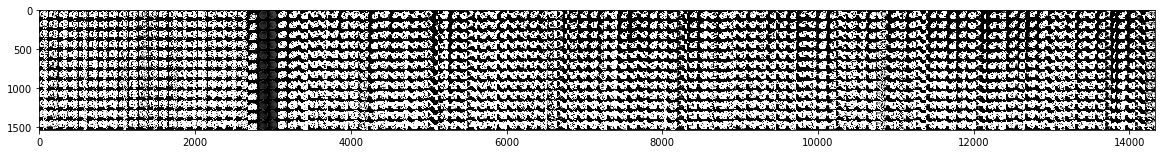

In [40]:
import sys, os
sys.path.append('../defacing')

import numpy as np
# from scipy.misc import toimage
from PIL import Image
from helpers.utils import save_vol, load_vol
from preprocessing.conform import conform_data
from preprocessing.normalization import clip, standardize, normalize
import glob
import matplotlib.pyplot as plt

conform_size = (128, 128, 128)
conform_zoom = (1.5, 1.5, 1.5)

testpath = '/work/01329/poldrack/data/mriqc-net/data/test_images/test1_images'

# for f in incorrect:
    
#     dname = f.split('/')[0]
#     fname = f.split('/')[1]
#     print(dname, fname)
    
#     file = os.path.join(testpath, f)
#     print(file)
    
#     cpath = '/work/06850/sbansal6/maverick2/mriqc-shared/test_conformed'
#     outfile = os.path.join(cpath, dname)
#     print(outfile)
#     os.makedirs(outfile, exist_ok=True)
    
#     outfile = os.path.join(outfile, fname)
#     print(outfile)
#     conform_data(file, 
#                  out_file=outfile, 
#                  out_size=conform_size, 
#                  out_zooms=conform_zoom)
    
#     vol,_,_ = load_vol(outfile)
    
#     vol = np.array(vol)
#     vol = np.transpose(vol, axes=[1, 2, 0])
    
#     plt.figure(figsize=(20, 10))
#     for i in range(1, 11):
#         plt.subplot(1, 10, i)
#         plt.imshow(vol[i,:,:])
    
#     plt.show()
    
cpaths = glob.glob('/work/06850/sbansal6/maverick2/mriqc-shared/test_conformed/*/*')

# images = []

# for v in cpaths:
    
    
#     vol, _, _ = load_vol(v)
#     vol = np.array(vol)
#     vol = clip(vol, q=90)
#     vol = normalize(vol)
#     vol = standardize(vol)
    
#     # get Coronal
# #     plt.figure(figsize=(20, 10))
# #     for i in range(1, 31):
# #         plt.subplot(1, 31, i)
# #         plt.imshow(vol[i+24,:,:])
    
#     plt.show()

#     for i in range(1, 13):
#         im = vol[i+24, :, :]
#         images.append(im)
        
print(len(images))

# images = np.array(images)*255

total_width = 128*12
total_height = 128*len(cpaths)
    
new_im = Image.new('RGB',(total_height, total_width))

nrows = len(cpaths)
ncols = 12
im_size = 128

print(new_im)
for im in range(len(images)):
    imag = Image.fromarray(images[im])
#     print(images[im].shape)
    x, y = im_size*int(im/ncols), im_size*int(im%ncols)
    new_im.paste(imag, (x,y))

new_im.save('mosaic/' + 'test_images_misclassified.png')
plt.figure(figsize=(20, 10))
plt.imshow(new_im)
plt.show()

[[ 255.  510.]
 [ 765. 1020.]]


In [ ]:
correct = 0
incorrect = 0

for vol in data['volume'].values:
    conf = data.loc[data['volume'] == vol, 'confidence'].item()
    label = data.loc[data['volume'] == vol, 'label'].item()
    
    if vol in tvolumes:
        if label == tvolumes[vol]:
            correct += 1
        else:
            incorrect += 1
    else:
        print(vol)
    

In [ ]:
from tensorboard.backend.event_processing import event_accumulator
import glob
combined_train_path = '/work/06850/sbansal6/maverick2/mriqc-shared/experiment_data_all/model_save_dir_F15/*/tb_logs/combined/train/*'

paths = glob.glob(combined_train_path)

print(paths[3])



In [ ]:
ea = event_accumulator.EventAccumulator(combined_train_path[5])
ea.Reload()



In [ ]:
csv_paths = glob.glob('/work/06850/sbansal6/maverick2/mriqc-shared/experiment_data_all/F15_csv/train/*')

# combined_train_csv = pd.read_csv()
average_train_accuracy = 0
for csv in csv_paths:
    accuracies = pd.read_csv(csv)["Value"].values
    average_train_accuracy += accuracies[-1]
    
average_train_accuracy = average_train_accuracy/15
print("Average 15 fold training accuracy for combined model: ", average_train_accuracy)

csv_paths = glob.glob('/work/06850/sbansal6/maverick2/mriqc-shared/experiment_data_all/F15_csv/validation/*')

# combined_train_csv = pd.read_csv()
average_valid_accuracy = 0
for csv in csv_paths:
    accuracies = pd.read_csv(csv)["Value"].values
    average_valid_accuracy += accuracies[-1]
#     print(accuracies[-1])
    
average_valid_accuracy = average_valid_accuracy/15
print("Average 15 fold validation accuracy for combined model: ", average_valid_accuracy)